In [84]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
from ocp_table_tpot.globals import Globals as gd
from tpot import TPOTRegressor
sys.path.insert(0,'..')

from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PolynomialFeatures,QuantileTransformer,Normalizer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.metrics import mean_squared_error,make_scorer
from copy import copy
from tpot.builtins import StackingEstimator


from src.models.model import mase,TimeSeriesSplitImproved
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,RANSACRegressor,Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from skgarden.quantile import RandomForestQuantileRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
import umap


df_tsfresh = pd.read_pickle(f'../data/processed/train_test_tsfresh_6.pkl').reset_index(level = 0)
data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')





In [85]:

year = 2019
tgt = 'rougher.output.recovery'

X = data_dict[year]['X_train_lagdiff']
print(X.shape)
y = data_dict[year]['y_train']
X_test = data_dict[year]['X_test_lagdiff']
mask = data_dict[year]['mask']
exclude_pts = data_dict[year]['excl'].set_index('date').tz_localize('UTC')
#mask_na_two_row=y[y[tgt].isna()].index.union(y[y[tgt].isna()].index + pd.Timedelta('1 hour')).union(y[y[tgt].isna()].index + pd.Timedelta('2 hour'))
inds = mask.index.difference(exclude_pts.index)

X=X.loc[inds,:]
y=y.loc[inds,:]
mask=mask[inds]
print(X.shape)
print(X_test.shape)

KeyError: 'X_train_lagdiff'

In [63]:
print(f'1) X shape: {X.shape},y: {y.shape}')
X = X[mask]
y = y[mask][tgt]
print(f'2) Train shape: {X.shape}')
X_filt = X.filter(regex  ="rougher|hour|dayw",axis = 1)
X = X_filt
train_df = pd.concat([X,y],axis= 1)
train_df.head()

1) X shape: (16063, 162),y: (16063, 7)
2) Train shape: (12838, 162)


,rougher.input.feed_fe,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_zn,rougher.input.floatbank10_copper_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_copper_sulfate,rougher.input.floatbank11_xanthate,...,diff_encod_val_rougher.input.feed_fe,diff_encod_rel_rougher.input.feed_fe,diff_encod_dif_rougher.input.feed_fe,diff_encod_val_rougher.input.feed_pb,diff_encod_rel_rougher.input.feed_pb,diff_encod_dif_rougher.input.feed_pb,diff_encod_val_rougher.input.feed_zn,diff_encod_rel_rougher.input.feed_zn,diff_encod_dif_rougher.input.feed_zn,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 01:00:00+00:00,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,...,-0.015314,0.012695,0.076049,-0.022780,0.000808,0.003901,0.065781,-0.010439,-0.073348,86.843261
2016-01-15 02:00:00+00:00,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,...,-0.021342,-0.004384,-0.023317,-0.019943,-0.036011,-0.086468,0.113966,-0.032622,-0.230327,86.842308
2016-01-15 03:00:00+00:00,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,...,-0.136885,0.008267,0.063739,-0.128119,-0.003443,0.006305,-0.140756,-0.014759,-0.103277,87.226430
2016-01-15 04:00:00+00:00,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,...,-0.307869,0.049940,0.325476,-0.013156,-0.117901,-0.237775,-0.332735,-0.019149,-0.121748,86.688794
2016-01-15 05:00:00+00:00,5.801920,1.879351,546.173470,57.469578,35.470082,5.687168,11.072517,6.200383,11.075009,6.202362,...,-0.023523,-0.040391,-0.235472,0.141421,-0.011055,-0.048945,0.293414,-0.043589,-0.269953,88.156912


In [64]:
#Fit Isolation RF
from sklearn.ensemble import IsolationForest
irf = IsolationForest(verbose =1,contamination='auto',behaviour='new')

irf.fit(train_df[X.columns])

irf_preds = irf.predict(train_df[X.columns])

(irf_preds > 0).sum()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


12664

## Create a function to fit a base model on `K-1` folds, predict on `1` fold

In [65]:
# This function takes one model and fit it to the train and test data
# It returns the model MASE, CV prediction, and test prediction
def base_fit(model, folds, features, target, trainData, testData):
    # Initialize empty lists and matrix to store data
    model_mase = []
    model_val_predictions = np.empty((trainData.shape[0], 1))
    k=0
    # Loop through the index in KFolds
    model_test_predictions=np.zeros((testData.shape[0],))
    model_val_true=np.zeros((trainData.shape[0],1))

    for train_index, val_index in folds.split(trainData):
        k=k+1
        # Split the train data into train and validation data
        train, validation = trainData.iloc[train_index], trainData.iloc[val_index]
        # Get the features and target
        train_features, train_target = train[features], train[target]
        validation_features, validation_target = validation[features], validation[target]
        
        # Fit the base model to the train data and make prediciton for validation data
        if (model.__class__ == xgb.sklearn.XGBRegressor) | (model.__class__ == lgb.sklearn.LGBMRegressor): 
            print('Fitting a boost model with limited tree rounds')
            evalset = [(validation_features,np.ravel(validation_target))]
            model.fit(train_features, np.ravel(train_target),eval_set =evalset,early_stopping_rounds = 20,verbose = False)
        else:
            model.fit(train_features, train_target.values)
        
        if (model.__class__ == xgb.sklearn.XGBRegressor):
            print(model.best_ntree_limit)
            print('Using xgboost with limited tree rounds')
            validation_predictions = model.predict(validation_features,ntree_limit = model.best_ntree_limit)

        elif (model.__class__ == lgb.sklearn.LGBMRegressor):
            print(model.best_iteration_)
            print('Using lgbmboost with limited tree rounds')
            validation_predictions = model.predict(validation_features,num_iteration = model.best_iteration_)
        else:
            print('Using generic predict')
            validation_predictions = model.predict(validation_features)
        
        
        # Calculate and store the MASE for validation data
        print(mase(validation_predictions,validation_target))
        #model_mase.append(mase(validation_predictions,validation_target))
        
        # Save the validation prediction for level 1 model training
        model_val_predictions[val_index, 0] = validation_predictions.reshape(validation.shape[0])
        model_val_true[val_index,0] = validation_target.values
        model_test_predictions += model.predict(testData[features])    
        
    model_test_predictions = model_test_predictions/k
    # Fit the base model to the whole training data
    #model.fit(trainData[features], np.ravel(trainData[target]))
    # Get base model prediction for the test data
    #model_test_predictions = model.predict(testData[features])
    # Calculate and store the MASE for validation data
        
    #model_val_predictions = model_val_predictions
    model_mase.append(mase(model_val_predictions,model_val_true))
    
    return(model_mase, model_val_predictions, model_test_predictions)

## Create a function to fit a dictionary of models, and get their OOF predictions from the training data

In [66]:
# Function that takes a dictionary of models and fits it to the data using baseFit
# The results of the models are then aggregated and returned for level 1 model training
def stacks(level0_models, folds, features, target, trainData, testData):
    num_models = len(level0_models.keys()) #Number of models
    
    # Initialize empty lists and matrix
    level0_trainFeatures = np.empty((trainData.shape[0], num_models))
    level0_testFeatures = np.empty((testData.shape[0], num_models))
    
    # Loop through the models
    for i, key in enumerate(level0_models.keys()):
        print('Fitting %s -----------------------' % (key))
        model_mase, val_predictions, test_predictions = base_fit(level0_models[key], folds, features, target, trainData, testData)
        
        # Print the average MASE for the model
        print('%s average MASE: %s' % (key, np.mean(model_mase)))
        print('\n')
        
        # Aggregate the base model validation and test data predictions
        level0_trainFeatures[:, i] = val_predictions.reshape(trainData.shape[0])
        level0_testFeatures[:, i] = test_predictions.reshape(testData.shape[0])
        
    return(level0_trainFeatures, level0_testFeatures)

## Create a function that trains a dictionary of stackers

In [67]:
# Function that takes a dictionary of classifiers and train them on base model predictions
def stackerTraining(stacker, folds, level0_trainFeatures, level0_testFeatures, trainData,target = None):
    for k in stacker.keys():
        print('Training stacker %s' % (k))
        stacker_model = stacker[k]
        stacker_mase = []
        y_pred = np.zeros_like(trainData[target].values)
        y_true =  np.zeros_like(trainData[target].values)
        for t, v in folds.split(X, y):
            train, validation = level0_trainFeatures[t,:], level0_trainFeatures[v,:]
            # Get the features and target
            train_features, train_target = train, trainData.iloc[t][target]
            validation_features, validation_target = validation, trainData.iloc[v][target]
            
            
            if (stacker_model.__class__ == xgb.sklearn.XGBRegressor) | (stacker_model.__class__ == lgb.sklearn.LGBMRegressor): 
                print('Fitting a boost model with limited tree rounds')
                evalset = [(validation_features,np.ravel(validation_target))]
                stacker_model.fit(train_features, np.ravel(train_target),eval_set =evalset,early_stopping_rounds = 20,verbose = False)
                print(stacker_model.best_iteration_)
            else:
                stacker_model.fit(level0_trainFeatures[t,:], train_target)
                
            y_pred[v] = stacker_model.predict(level0_trainFeatures[v])
            y_true[v] = trainData.iloc[v][target].values
        
        stacker_mase =mase(y_pred,y_true)
        average_mase = mase(level0_trainFeatures.mean(axis=1),y_true)
        print('%s Stacker MASE: %s' % (k, stacker_mase))
        print('%s Averaging MASE: %s' % (k, average_mase))

        
        

In [68]:
# Get the K fold indexes
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=False, random_state=156)

## Set up the dictionaries of level 0 and level 1 models

In [69]:
# A dictionary of base models
scaler = make_pipeline(QuantileTransformer(output_distribution='normal'),PCA(whiten=True))
level0_models = {}
# level0_models['Lasso'] = make_pipeline(scaler, Lasso(alpha =0.005, random_state=1,max_iter = 2000))
# level0_models['ElasticNet'] = make_pipeline(scaler,ElasticNet(alpha = 0.001))
# level0_models['XGB_rougher_base_a'] = xgb.XGBRegressor(learning_rate=0.05,
#                             n_estimators=400,**{'max_depth': 7, 'gamma': '44.954', 'colsample_bytree': '0.395', 'subsample': '0.993', 'min_child_weight': '133.132'},
#                             silent=1,
#                              random_state =48, nthread = -1)

# level0_models['XGB_rougher_base_b'] =xgb.XGBRegressor(learning_rate=0.05,
#                             n_estimators=400,**{'max_depth': 7, 'gamma': '44.954', 'colsample_bytree': '0.395', 'subsample': '0.993', 'min_child_weight': '133.132'},
#                             silent=1,
#                              random_state =38, nthread = -1)

# # level0_models['XGB_rougher_base_c'] = xgb.XGBRegressor(learning_rate=0.05,
# #                             n_estimators=400,**{'max_depth': 4, 'gamma': '5.102', 'colsample_bytree': '0.344', 'subsample': '0.884', 'min_child_weight': '9.622'},
# #                             silent=1,
# #                              random_state =82, nthread = -1)

# # level0_models['XGB_rougher_base_d'] = xgb.XGBRegressor(learning_rate=0.05,
# #                             n_estimators=400,**{'max_depth': 5, 'gamma': '3.906', 'colsample_bytree': '0.401', 'subsample': '0.760', 'min_child_weight': '9.563'},
# #                             silent=1,
# #                              random_state =11, nthread = -1)


level0_models['LGBM_rougher_base_a'] = lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=500,random_state=91,
                              **{'max_depth': 5, 'num_leaves': 40, 'feature_fraction': '0.453', 'bagging_fraction': '0.276'})

level0_models['LGBM_rougher_base_b'] =lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=500,random_state=92,
                              **{'max_depth': 4, 'num_leaves': 180, 'feature_fraction': '0.322', 'bagging_fraction': '0.150'})
level0_models['LGBM_rougher_base_c'] =lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=500,random_state=93,
                              ** {'max_depth': 5, 'num_leaves': 80, 'feature_fraction': '0.440', 'bagging_fraction': '0.666'})
level0_models['LGBM_rougher_base_d'] =lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=500,random_state=94,
                             **{'max_depth': 6, 'num_leaves': 25, 'feature_fraction': '0.555', 'bagging_fraction': '0.257'})
level0_models['LGBM_rougher_base_e']= lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=500,random_state=7,
                              **{'max_depth': 4, 'num_leaves': 30, 'feature_fraction': '0.658', 'bagging_fraction': '0.863'})





In [70]:
# Train all the base models in the dictionary
level0_trainFeatures_rougher, level0_testFeatures_rougher = stacks(level0_models, kf, X.columns, tgt, train_df, X_test)


Fitting LGBM_rougher_base_a -----------------------
Fitting a boost model with limited tree rounds
92
Using lgbmboost with limited tree rounds
2.7974777471725636
Fitting a boost model with limited tree rounds
139
Using lgbmboost with limited tree rounds
2.48813305867569
Fitting a boost model with limited tree rounds
44
Using lgbmboost with limited tree rounds
2.1760970633201353
Fitting a boost model with limited tree rounds
111
Using lgbmboost with limited tree rounds
1.8572920183959611
Fitting a boost model with limited tree rounds
54
Using lgbmboost with limited tree rounds
2.8807535440966827
LGBM_rougher_base_a average MASE: 2.4697535908211443


Fitting LGBM_rougher_base_b -----------------------
Fitting a boost model with limited tree rounds
201
Using lgbmboost with limited tree rounds
2.741131763449133
Fitting a boost model with limited tree rounds
235
Using lgbmboost with limited tree rounds
2.4414468644420366
Fitting a boost model with limited tree rounds
44
Using lgbmboost with

In [71]:
# A dictionary of level 1 model to train on base model predictions
stacker = {
            'Enet': ElasticNet(alpha = 0.001),
#           'BR':BayesianRidge(n_iter = int(3e3)),
#           'Ridge1':Ridge(),
            'Ridge50':Ridge(alpha=60),
           'Ridge1e2':Ridge(alpha=1e2),
           'Ridge5e2':Ridge(alpha=5e2),
           'Ridge1e3':Ridge(alpha=1e3),
           'Ridge5e3':Ridge(alpha=5e3),
          'Lasso': Lasso(alpha =0.005, random_state=1,max_iter = 2000),
      'positive_Lasso': Lasso(alpha=0.0001,precompute=True,max_iter=1000, positive=True, random_state=9999, selection='random'),
          'LGBM': lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.07, n_estimators=500,random_state=38,
                              **{'max_depth': 4, 'num_leaves': 32, 'feature_fraction': '0.8', 'bagging_fraction': '0.8'})}

stackerTraining(stacker, kf, level0_trainFeatures_rougher, level0_testFeatures_rougher, train_df,target = tgt)
level1_model = stacker['Enet'].fit(level0_trainFeatures_rougher,train_df[tgt])
level1_test_pred_rougher = level1_model.predict(level0_testFeatures_rougher)
rougher_meta_train = level0_trainFeatures_rougher
rougher_meta_test = level0_testFeatures_rougher

level1_test_pred_rougher.shape

Training stacker Enet
Enet Stacker MASE: 2.3989524501228456
Enet Averaging MASE: 2.4344148267003733
Training stacker Ridge50
Ridge50 Stacker MASE: 2.399360358701386
Ridge50 Averaging MASE: 2.4344148267003733
Training stacker Ridge1e2
Ridge1e2 Stacker MASE: 2.3997044051912977
Ridge1e2 Averaging MASE: 2.4344148267003733
Training stacker Ridge5e2
Ridge5e2 Stacker MASE: 2.403506721525717
Ridge5e2 Averaging MASE: 2.4344148267003733
Training stacker Ridge1e3
Ridge1e3 Stacker MASE: 2.408535376527629
Ridge1e3 Averaging MASE: 2.4344148267003733
Training stacker Ridge5e3
Ridge5e3 Stacker MASE: 2.4414626950181773
Ridge5e3 Averaging MASE: 2.4344148267003733
Training stacker Lasso
Lasso Stacker MASE: 2.399394360660026
Lasso Averaging MASE: 2.4344148267003733
Training stacker positive_Lasso
positive_Lasso Stacker MASE: 2.4462491541328926
positive_Lasso Averaging MASE: 2.4344148267003733
Training stacker LGBM
Fitting a boost model with limited tree rounds
25
Fitting a boost model with limited tree ro

(5856,)

# Let's try to figure out the stacking Level 2

In [72]:
def solve_pg(A, b, momentum=0.9, maxiter=1000):
    from cvxpy import Variable,Parameter,Minimize,square,norm,Problem
    M, N = A.shape
    x = np.zeros(N)

    AtA = A.T.dot(A)
    Atb = A.T.dot(b)

    stop_count = 0

    # projection helper
    x_ = Variable(N)
    v_ = Parameter(N)
    objective_ =  Minimize(0.5 * norm(x_ - v_, 1))
    constraints_ = [sum(x_) == 1]
    problem_ = Problem(objective_, constraints_)

    def gradient(x):
        return AtA.dot(x) - Atb

    def obj(x):
        return 0.5 * np.linalg.norm(A.dot(x) - b,ord=1)

    it = 0
    while True:
        grad = gradient(x)

        # line search
        alpha = 1
        beta = 0.5
        sigma=1e-2
        old_obj = obj(x)
        while True:
            new_x = x - alpha * grad
            new_obj = obj(new_x)
            if old_obj - new_obj >= sigma * grad.dot(x - new_x):
                break
            else:
                alpha *= beta

        x_old = x[:]
        x = x - alpha*grad

        # projection
        v_.value = x
        problem_.solve()
        x = np.array(x_.value.flat)

        y = x + momentum * (x - x_old)

        if np.abs(old_obj - obj(x)) < 1e-2:
            stop_count += 1
        else:
            stop_count = 0

        if stop_count == 3:
            print('early-stopping @ it: ', it)
            return x

        it += 1

        if it == maxiter:
            return x

x = solve_pg(level0_trainFeatures_rougher, train_df[tgt].values)
print('sum x: ', np.sum(x))
print(mase(level0_trainFeatures_rougher.dot(x),train_df[tgt].values))


early-stopping @ it:  7
sum x:  1.0000000000000089
2.434392691244788


# Repeat the procedure with Final

In [73]:
year = 2019
tgt = 'final.output.recovery'

X = data_dict[year]['X_train_lagdiff']
y = data_dict[year]['y_train']
X_test = data_dict[year]['X_test_lagdiff']

mask = data_dict[year]['mask']
exclude_pts = data_dict[year]['excl'].set_index('date').tz_localize('UTC')
#mask_na_two_row=y[y[tgt].isna()].index.union(y[y[tgt].isna()].index + pd.Timedelta('1 hour')).union(y[y[tgt].isna()].index + pd.Timedelta('2 hour'))
inds = mask.index.difference(exclude_pts.index)
print(X.shape)

X=X.loc[inds,:]
y=y.loc[inds,:]
mask=mask[inds]
print(X.shape)

print(f'1) X shape: {X.shape},y: {y.shape}')
X = X[mask]
y = y[mask][tgt]

train_df = pd.concat([X,y],axis= 1)
print(f'1) X shape: {X.shape},y: {y.shape}')
print(X_test.shape)
train_df.head()

(16860, 162)
(16063, 162)
1) X shape: (16063, 162),y: (16063, 7)
1) X shape: (12838, 162),y: (12838,)
(5856, 162)


,primary_cleaner.input.copper_sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,diff_encod_val_primary_cleaner.input.feed_size,diff_encod_rel_primary_cleaner.input.feed_size,diff_encod_dif_primary_cleaner.input.feed_size,diff_encod_val_primary_cleaner.input.depressant,diff_encod_rel_primary_cleaner.input.depressant,diff_encod_dif_primary_cleaner.input.depressant,diff_encod_val_primary_cleaner.input.copper_sulfate,diff_encod_rel_primary_cleaner.input.copper_sulfate,diff_encod_dif_primary_cleaner.input.copper_sulfate,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 01:00:00+00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,-0.121599,0.015690,0.121599,0.424378,-0.024796,-0.256423,2.799889,-0.032924,-4.262660,69.266198
2016-01-15 02:00:00+00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,-0.096094,0.012399,0.096094,-0.176612,0.097614,1.196641,1.523430,-0.026193,-3.332854,68.116445
2016-01-15 03:00:00+00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,-0.043203,0.005575,0.043203,0.149852,-0.012249,-0.143992,-3.974678,0.019956,2.425058,68.347543
2016-01-15 04:00:00+00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,-0.010154,0.001310,0.010154,0.062203,0.036551,0.529270,-6.872177,0.023163,2.590159,66.927016
2016-01-15 05:00:00+00:00,115.581252,12.470773,7.25,0.965760,1602.964922,-498.090944,1602.074298,-500.179481,1602.154812,-498.642614,...,-0.030205,0.003897,0.030205,-0.208391,0.051965,0.765551,2.798943,-0.043619,-5.205860,69.465816


## Create dicts of stackers and base models

In [74]:
# A dictionary of base models
scaler = make_pipeline(QuantileTransformer(output_distribution='normal'),PCA(whiten=True))
level0_models = {}
# level0_models['Lasso'] = make_pipeline(scaler, Lasso(alpha =0.005, random_state=1,max_iter = 2000))
# level0_models['ElasticNet'] = make_pipeline(scaler,ElasticNet(alpha = 0.001))
def fair_obj(preds, dtrain):
    """y = c * abs(x) - c**2 * np.log(abs(x)/c + 1)"""
    x = preds - dtrain.get_labels()
    c = 1
    den = abs(x) + c
    grad = c*x / den
    hess = c*c / den ** 2
    return grad, hess

# level0_models['XGB_final_base_a'] = xgb.XGBRegressor(learning_rate=0.05,
#                             n_estimators=400,**{'max_depth': 3, 'gamma': '17.158', 'colsample_bytree': '0.442', 'subsample': '0.644', 'min_child_weight': '9.733'},
#                             silent=1,
#                              random_state =48, nthread = -1)

# level0_models['XGB_final_base_b'] =xgb.XGBRegressor(learning_rate=0.05,
#                             n_estimators=400,**{'max_depth': 4, 'gamma': '18.571', 'colsample_bytree': '0.745', 'subsample': '0.681', 'min_child_weight': '9.024'},
#                             silent=1,
#                              random_state =38, nthread = -1)

# level0_models['XGB_final_base_c'] = xgb.XGBRegressor(learning_rate=0.05,
#                             n_estimators=400,**{'max_depth': 2, 'gamma': '16.491', 'colsample_bytree': '0.522', 'subsample': '0.844', 'min_child_weight': '5.096'},
#                             silent=1,
#                              random_state =82, nthread = -1)

# level0_models['XGB_final_base_d'] = xgb.XGBRegressor(learning_rate=0.05,
#                             n_estimators=400,**{'max_depth': 3, 'gamma': '16.766', 'colsample_bytree': '0.540', 'subsample': '0.774', 'min_child_weight': '12.674'},
#                             silent=1,
#                              random_state =11, nthread = -1)

level0_models['LGBM_final_base_a'] = lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=400,random_state=96,
                              **{'max_depth': 8, 'num_leaves': 150, 'feature_fraction': '0.645', 'bagging_fraction': '0.425'})

level0_models['LGBM_final_base_b'] =lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=400,random_state=973,
                              **{'max_depth': 6, 'num_leaves': 15, 'feature_fraction': '0.826', 'bagging_fraction': '0.919'})

level0_models['LGBM_final_base_c'] =lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=400,random_state=937,
                              **{'max_depth': 4, 'num_leaves': 195, 'feature_fraction': '0.586', 'bagging_fraction': '0.110'})
level0_models['LGBM_final_base_d'] =lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=400,random_state=49,
                              **{'max_depth': 4, 'num_leaves': 210, 'feature_fraction': '0.635', 'bagging_fraction': '0.326'})



# level0_models['LGBM_final_base_e'] = lgb.LGBMRegressor(objective=obj,
#                               learning_rate=0.07, n_estimators=500,random_state=7,
#                               **{'max_depth': 4, 'num_leaves': 63, 'feature_fraction': '0.89', 'bagging_fraction': '0.757'})
# level0_models['LGBM_final_base_f'] = lgb.LGBMRegressor(objective=obj,
#                               learning_rate=0.07, n_estimators=500,random_state=8,
#                               **{'max_depth': 4, 'num_leaves': 63, 'feature_fraction': '0.879', 'bagging_fraction': '0.727'})
# level0_models['LGBM_final_base_g'] = lgb.LGBMRegressor(objective=obj,
#                               learning_rate=0.07, n_estimators=500,random_state=9,
#                               **{'max_depth': 5, 'num_leaves': 65, 'feature_fraction': '0.879', 'bagging_fraction': '0.727'})
# level0_models['LGBM_final_base_h'] = lgb.LGBMRegressor(objective=obj,
#                               learning_rate=0.07, n_estimators=500,random_state=10,
#                               **{'max_depth': 4, 'num_leaves': 60, 'feature_fraction': '0.797', 'bagging_fraction': '0.982'})
# level0_models['LGBM_final_base_i'] = lgb.LGBMRegressor(objective=obj,
#                               learning_rate=0.07, n_estimators=500,random_state=12,
#                               **{'max_depth': 5, 'num_leaves': 60, 'feature_fraction': '0.8', 'bagging_fraction': '0.92'})



# #level0_models['KNN_final_a'] = make_pipeline(scaler,KNeighborsRegressor(n_jobs = -1,**{'n_neighbors': 254, 'weights': 'distance', 'leaf_size': 16}))
#level0_models['KNN_final_b'] = make_pipeline(scaler,KNeighborsRegressor(n_jobs = -1,**{'n_neighbors': 50, 'weights': 'distance', 'leaf_size': 18}))
#level0_models['KNN_final_c'] = make_pipeline(scaler,KNeighborsRegressor(n_jobs = -1,**{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 30.0}))
# level0_models['KNN_final_d'] = make_pipeline(scaler,KNeighborsRegressor(n_jobs = -1,**{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 24.0}))
#level0_models['KNN_rougher_b_bray'] = make_pipeline(scaler,KNeighborsRegressor(n_jobs = -1,**{'n_neighbors': 50, 'weights': 'distance','metric':'braycurtis', 'leaf_size': 18}))
#level0_models['KNN_rougher_c_bray'] = make_pipeline(scaler,KNeighborsRegressor(n_jobs = -1,**{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 30.0,'metric':'braycurtis'}))
# level0_models['KNN_rougher_d_bray'] = make_pipeline(scaler,KNeighborsRegressor(n_jobs = -1,**{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 24.0,'metric':'braycurtis'}))




In [75]:
# Train all the base models in the dictionary
level0_trainFeatures_final, level0_testFeatures_final = stacks(level0_models, kf, X.columns, tgt, train_df, X_test)

Fitting LGBM_final_base_a -----------------------
Fitting a boost model with limited tree rounds
82
Using lgbmboost with limited tree rounds
1.7858212161759284
Fitting a boost model with limited tree rounds
60
Using lgbmboost with limited tree rounds
1.8116885475856477
Fitting a boost model with limited tree rounds
69
Using lgbmboost with limited tree rounds
1.8285020850937794
Fitting a boost model with limited tree rounds
267
Using lgbmboost with limited tree rounds
1.537952155992026
Fitting a boost model with limited tree rounds
195
Using lgbmboost with limited tree rounds
1.4202945285904598
LGBM_final_base_a average MASE: 1.6603748023808749


Fitting LGBM_final_base_b -----------------------
Fitting a boost model with limited tree rounds
58
Using lgbmboost with limited tree rounds
1.8209566906440673
Fitting a boost model with limited tree rounds
70
Using lgbmboost with limited tree rounds
1.7688576581276982
Fitting a boost model with limited tree rounds
55
Using lgbmboost with limit

In [76]:
# A dictionary of level 1 model to train on base model predictions
stacker = {
           'Enet': ElasticNet(alpha = 0.001),
          #'RF':RandomForestRegressor(max_depth = 3,n_estimators=200),
          'BR':BayesianRidge(n_iter = int(3e3)),
          'Ridge1':Ridge(),
          'Ridge1e2':Ridge(alpha=1e2),
          'Ridge5e2':Ridge(alpha=5e2),
          'Ridge1e3':Ridge(alpha=1e3),
          'Ridge5e3':Ridge(alpha=5e3),
          'Lasso': Lasso(alpha =0.005, random_state=1,max_iter = 2000),
          'LGBM': lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.07, n_estimators=500,random_state=40,
                              **{'max_depth': 3, 'num_leaves':8, 'feature_fraction': '0.9', 'bagging_fraction': '0.7'})}

stackerTraining(stacker, kf, level0_trainFeatures_final, level0_testFeatures_final, train_df,target = tgt)
level1_model = stacker['LGBM'].fit(level0_trainFeatures_final,train_df[tgt])
level1_test_pred_final = level1_model.predict(level0_testFeatures_final)
level1_test_pred_final.shape

Training stacker Enet
Enet Stacker MASE: 1.706320831399641
Enet Averaging MASE: 1.6328787523299373
Training stacker BR
BR Stacker MASE: 1.7060853583241073
BR Averaging MASE: 1.6328787523299373
Training stacker Ridge1
Ridge1 Stacker MASE: 1.7063509918272197
Ridge1 Averaging MASE: 1.6328787523299373
Training stacker Ridge1e2
Ridge1e2 Stacker MASE: 1.7061281787412441
Ridge1e2 Averaging MASE: 1.6328787523299373
Training stacker Ridge5e2
Ridge5e2 Stacker MASE: 1.7054195734738586
Ridge5e2 Averaging MASE: 1.6328787523299373
Training stacker Ridge1e3
Ridge1e3 Stacker MASE: 1.7048117982619522
Ridge1e3 Averaging MASE: 1.6328787523299373
Training stacker Ridge5e3
Ridge5e3 Stacker MASE: 1.7035837923085486
Ridge5e3 Averaging MASE: 1.6328787523299373
Training stacker Lasso
Lasso Stacker MASE: 1.7058483538054465
Lasso Averaging MASE: 1.6328787523299373
Training stacker LGBM
Fitting a boost model with limited tree rounds
18
Fitting a boost model with limited tree rounds
26
Fitting a boost model with l

(5856,)

In [ ]:
x

## Make a submission:

In [82]:
preds = pd.DataFrame(data = {'date':X_test.index,'rougher.output.recovery':level1_test_pred_rougher, 'final.output.recovery':level0_testFeatures_final.mean(axis=1)})
stacked_preds_sub = preds
stacked_preds_sub['date'] = stacked_preds_sub['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
stacked_preds_sub.set_index('date',inplace=True)
#stacked_preds_sub.drop_duplicates(inplace=True)
stacked_preds_sub.to_csv('../results/stacked_sub_lgb_lasso_base_alldata_tsclean_fixed_lgbm_lagdiff.csv')

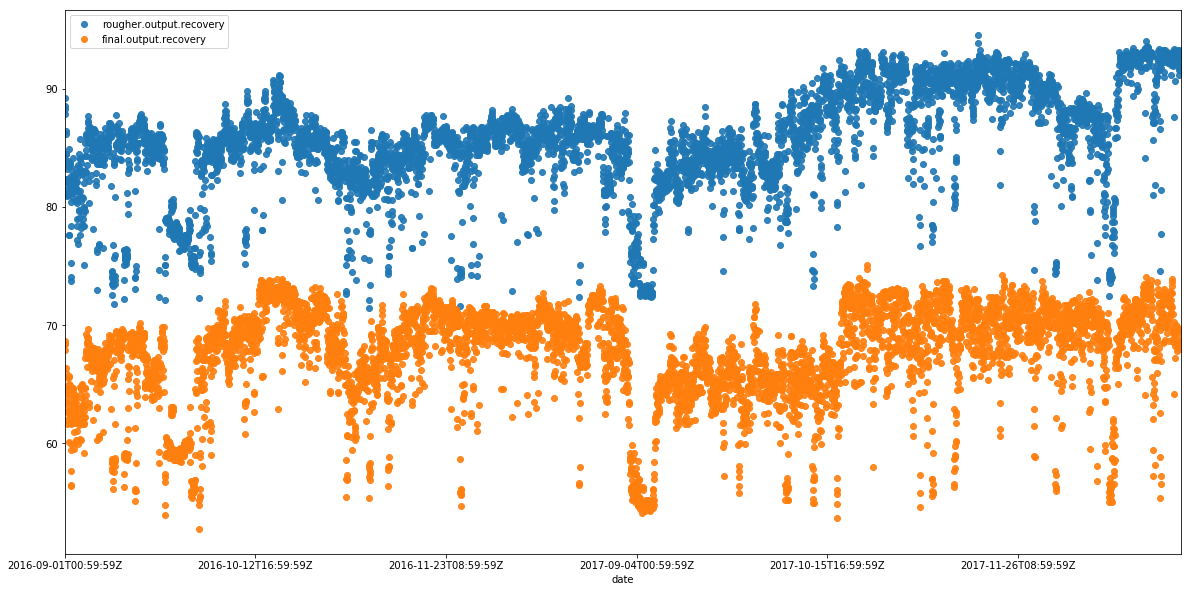

In [83]:
stacked_preds_sub.plot(style=['o','o'],figsize = (20,10),alpha=0.9)


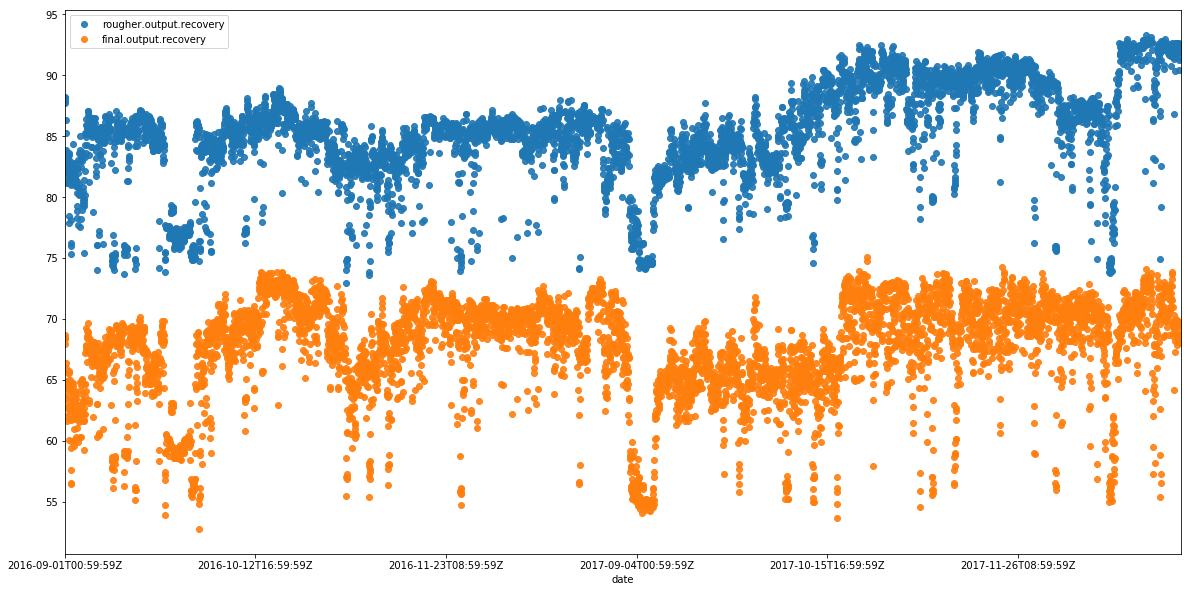

In [79]:
preds_av = pd.DataFrame(data = {'date':X_test.index,'rougher.output.recovery':level0_testFeatures_rougher.mean(axis=1), 'final.output.recovery':level0_testFeatures_final.mean(axis=1)})

preds_av['date'] = preds_av['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
preds_av.set_index('date',inplace=True)
preds_av.plot(figsize = (20,10),style=['o','o'],alpha=0.9)

#preds_av.to_csv('../results/stacked_sub_lgb_lasso_base_alldata_tsclean_r-filt-f-meta.fixed_best_mod_averaged_lagdiff.csv')

In [ ]:
r = np.power(level0_testFeatures_rougher.prod(axis=1),1/level0_testFeatures_rougher.shape[1])
f = np.power(level0_testFeatures_final.prod(axis=1),1/level0_testFeatures_final.shape[1])

preds_av = pd.DataFrame(data = {'date':X_test.index,'rougher.output.recovery':r, 'final.output.recovery':f})
preds_av['date'] = preds_av['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
preds_av.set_index('date',inplace=True)
preds_av.plot(figsize = (20,10),style=['o','o'],alpha=0.9)